In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import random


In [ ]:
# define needed columns
desired_columns=["timestamp", "avg cpu"]
new_column_names = {"timestamp": "time", "avg cpu": "avg_cpu"}

#read the csv file and then specify the desired columns
df=pd.read_csv("cpu_util.csv", usecols=desired_columns, parse_dates=["timestamp"])

#rename columns to new names
df=df.rename(columns=new_column_names)

#set the time column to index and make it into period
df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)
df=df.set_index("time")

<ipython-input-12-d89af7c8c5f6>:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


In [ ]:
df.head()

,avg_cpu
time,
2017-01-01 00:00:00,1.229569e+06
2017-01-01 00:05:00,1.211322e+06
2017-01-01 00:10:00,1.206635e+06
2017-01-01 00:15:00,1.190369e+06
2017-01-01 00:20:00,1.180992e+06


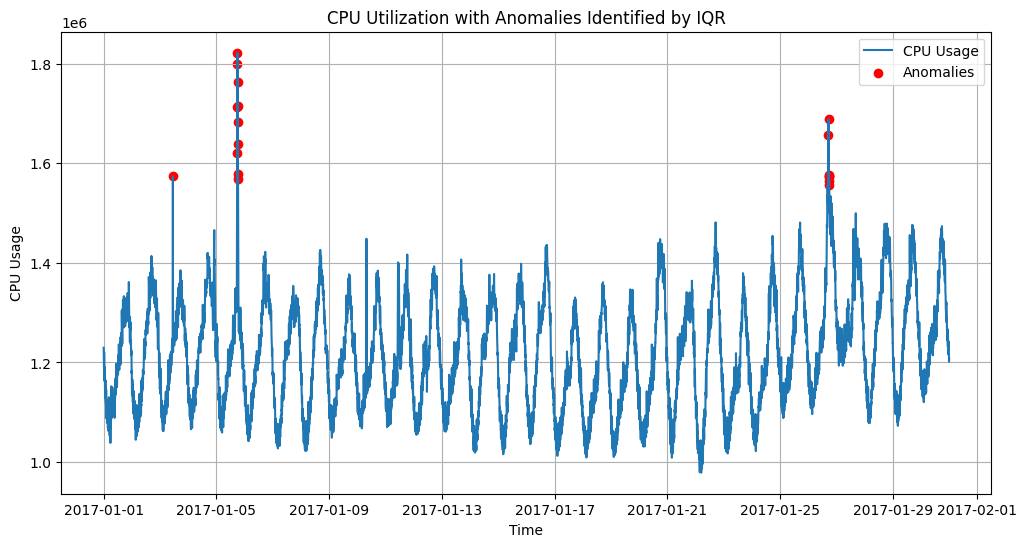

In [ ]:
# Calculate IQR
Q1 = df['avg_cpu'].quantile(0.25)
Q3 = df['avg_cpu'].quantile(0.75)
IQR = Q3 - Q1

# Define a threshold to identify anomalies (e.g., 1.5 * IQR)
iqr_threshold = 1.5
lower_bound = Q1 - iqr_threshold * IQR
upper_bound = Q3 + iqr_threshold * IQR
anomalies_iqr = df[(df['avg_cpu'] < lower_bound) | (df['avg_cpu'] > upper_bound)]

# Mark anomalies
df['anomaly'] = (df['avg_cpu'] < lower_bound) | (df['avg_cpu'] > upper_bound)

# Plot the anomalies
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['avg_cpu'], label='CPU Usage')
plt.scatter(anomalies_iqr.index, anomalies_iqr['avg_cpu'], color='red', label='Anomalies')
plt.title('CPU Utilization with Anomalies Identified by IQR')
plt.xlabel('Time')
plt.ylabel('CPU Usage')
plt.legend()
plt.grid(True)
plt.show()

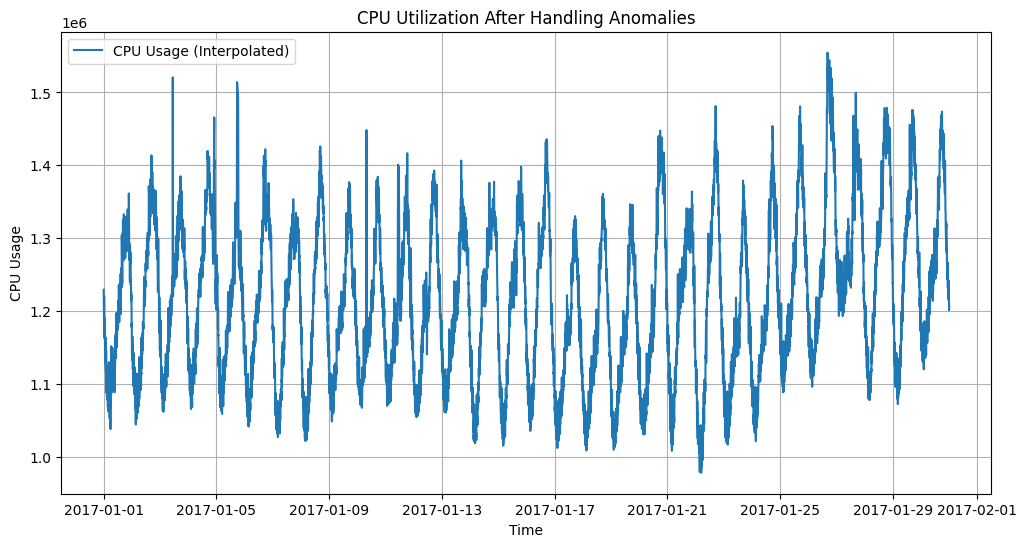

In [ ]:
# Interpolating anomalies
df['avg_cpu'] = np.where(df['anomaly'] == True, np.nan, df['avg_cpu'])
df['avg_cpu'] = df['avg_cpu'].interpolate(method='time')

# Drop the anomaly column as it's no longer needed
df = df.drop(columns=['anomaly'])

# Plot the data after interpolation
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['avg_cpu'], label='CPU Usage (Interpolated)')
plt.title('CPU Utilization After Handling Anomalies')
plt.xlabel('Time')
plt.ylabel('CPU Usage')
plt.legend()
plt.grid(True)
plt.show()

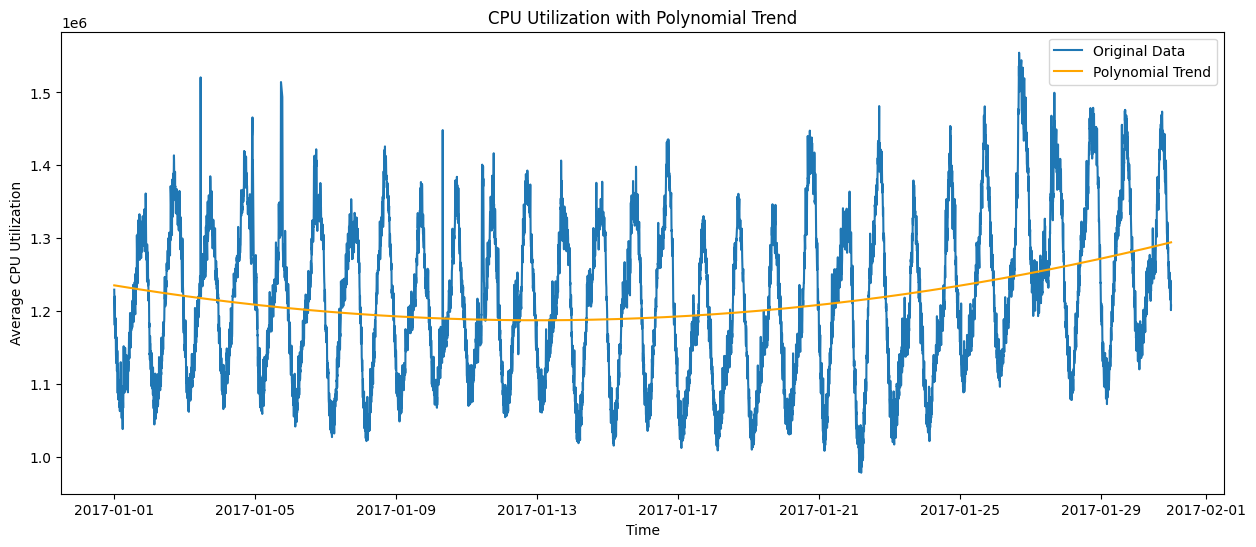

In [ ]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Convert the time index to numerical values (e.g., the number of minutes since the start)
time_numeric = np.arange(len(df)).reshape(-1, 1)

# Define the degree of the polynomial
degree = 2  # You can experiment with different degrees

# Create polynomial features
poly = PolynomialFeatures(degree=degree)
time_poly = poly.fit_transform(time_numeric)

# Fit the polynomial regression model
model = LinearRegression()
model.fit(time_poly, df['avg_cpu'])

# Predict the trend
trend = model.predict(time_poly)
df['trend'] = trend

# Plot the original data and the polynomial trend
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['avg_cpu'], label='Original Data')
plt.plot(df.index, df['trend'], label='Polynomial Trend', color='orange')
plt.title('CPU Utilization with Polynomial Trend')
plt.xlabel('Time')
plt.ylabel('Average CPU Utilization')
plt.legend()
plt.show()


In [ ]:
df.head()

,avg_cpu,trend
time,,
2017-01-01 00:00:00,1.229569e+06,1.235517e+06
2017-01-01 00:05:00,1.211322e+06,1.235489e+06
2017-01-01 00:10:00,1.206635e+06,1.235462e+06
2017-01-01 00:15:00,1.190369e+06,1.235434e+06
2017-01-01 00:20:00,1.180992e+06,1.235407e+06


In [ ]:
# Pre-processing

# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)

# Function to create Fourier series
def create_fourier_series(df, period, order):
    t = np.arange(len(df))
    for k in range(1, order + 1):
        df[f'sin_{period}_{k}'] = np.sin(2 * np.pi * k * t / period)
        df[f'cos_{period}_{k}'] = np.cos(2 * np.pi * k * t / period)
    return df

# Load the dataset
file_path = 'cpu_util.csv'
df = pd.read_csv(file_path, usecols=["timestamp", "avg cpu"], parse_dates=["timestamp"])
df = df.rename(columns={"timestamp": "time", "avg cpu": "avg_cpu"})
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Add Fourier series features
df = create_fourier_series(df, period=24, order=3)
df = create_fourier_series(df, period=24 * 7, order=3)

# Add more lag features
max_lag = 36
for lag in range(1, max_lag + 1):
    df[f'avg_cpu_lag_{lag}'] = df['avg_cpu'].shift(lag)
df.dropna(inplace=True)

# Normalize the features and target separately
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

features = feature_scaler.fit_transform(df.drop(columns=['avg_cpu']))
target = target_scaler.fit_transform(df['avg_cpu'].values.reshape(-1, 1)).reshape(-1)

# Function to create sliding windows with features
def create_sliding_windows_with_features(data, target, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(target[i+window_size])
    return np.array(X), np.array(y)

window_size = 50
X, y = create_sliding_windows_with_features(features, target, window_size)

In [ ]:
# Split the data into training, validation, and testing sets
total_samples = len(X)
train_size = int(total_samples * 0.7)
val_size = int(total_samples * 0.2)
test_size = total_samples - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# Flatten the input data for the Random Forest model
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)


Baseline Model

In [ ]:
# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=seed)
rf_model.fit(X_train_flat, y_train)

# Make predictions
train_predictions = rf_model.predict(X_train_flat)
val_predictions = rf_model.predict(X_val_flat)
test_predictions = rf_model.predict(X_test_flat)

In [ ]:
# Rescale predictions back to original scale
train_predictions_rescaled = target_scaler.inverse_transform(train_predictions.reshape(-1, 1)).reshape(-1)
val_predictions_rescaled = target_scaler.inverse_transform(val_predictions.reshape(-1, 1)).reshape(-1)
test_predictions_rescaled = target_scaler.inverse_transform(test_predictions.reshape(-1, 1)).reshape(-1)
y_train_rescaled = target_scaler.inverse_transform(y_train.reshape(-1, 1)).reshape(-1)
y_val_rescaled = target_scaler.inverse_transform(y_val.reshape(-1, 1)).reshape(-1)
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)

Training MAE: 4576.87163918619, Training MAPE: 0.0037619096374052812, Training Accuracy: 0.9962380903625947
Validation MAE: 18984.333919296994, Validation MAPE: 0.015079456061898056, Validation Accuracy: 0.9849205439381019
Test MAE: 19269.15669643914, Test MAPE: 0.014763135442607564, Test Accuracy: 0.9852368645573925


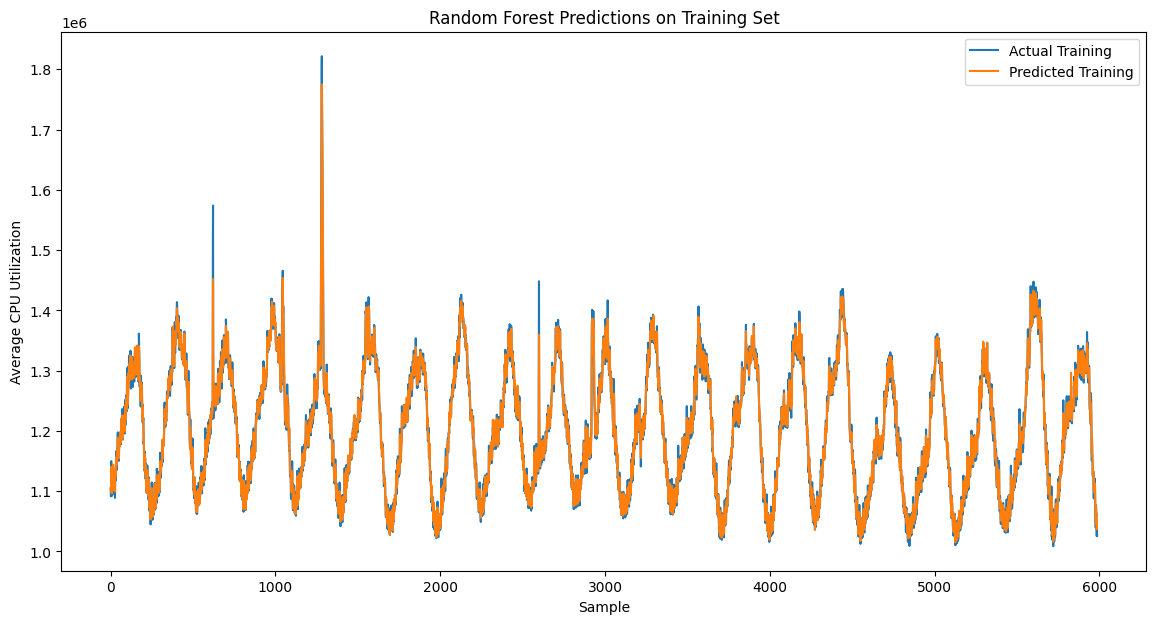

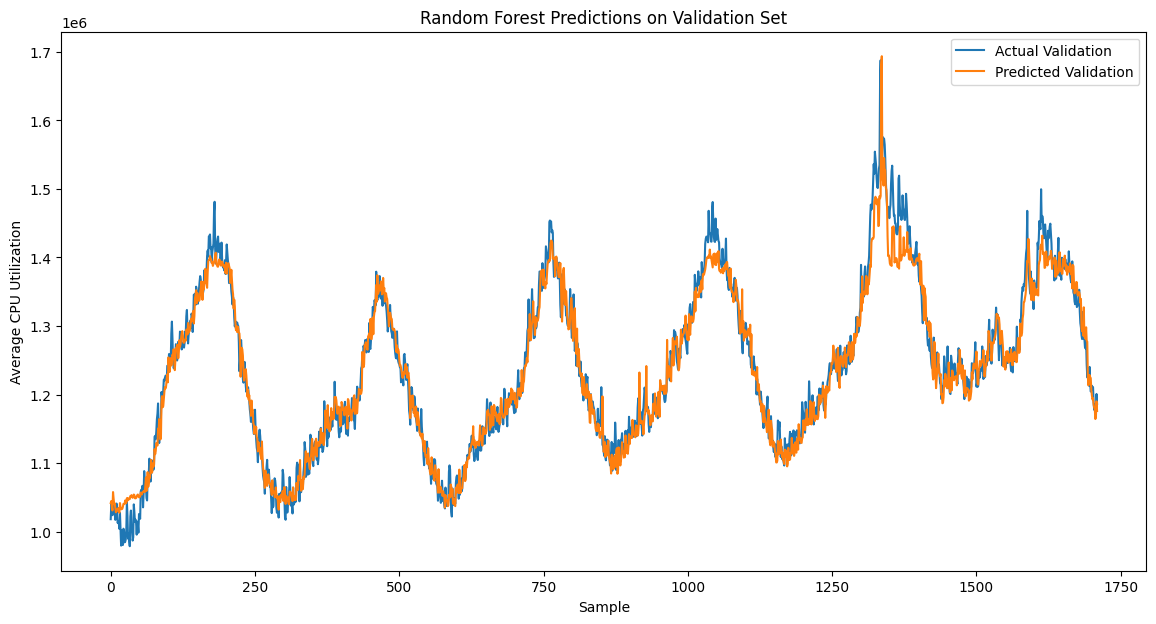

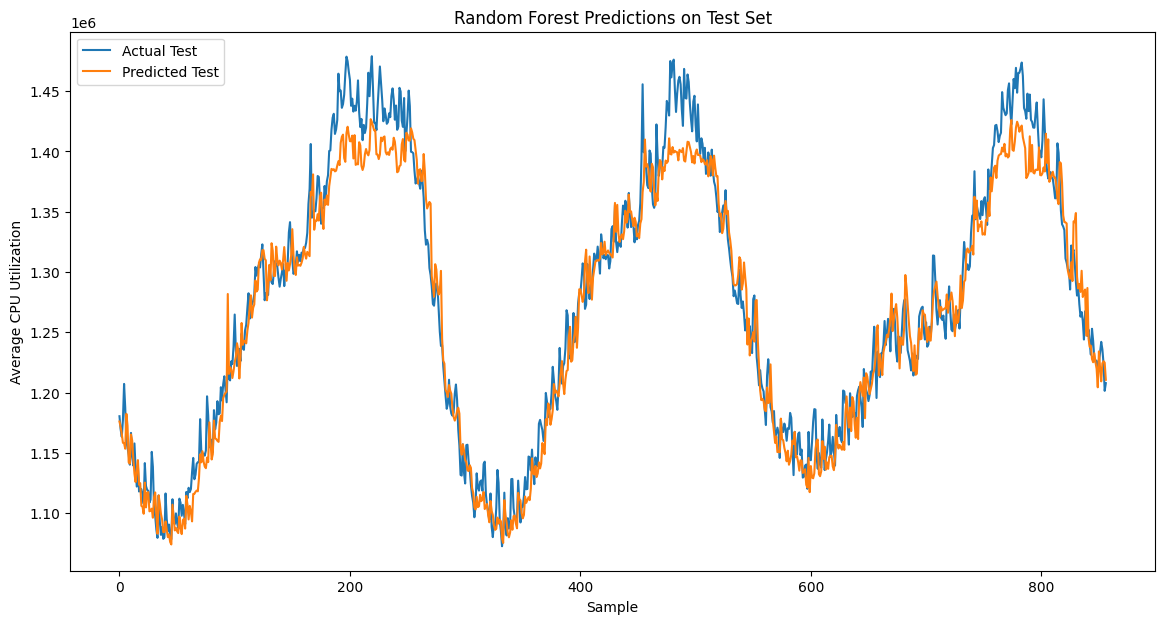

In [ ]:
# Evaluate the model
train_mae = mean_absolute_error(y_train_rescaled, train_predictions_rescaled)
train_mape = mean_absolute_percentage_error(y_train_rescaled, train_predictions_rescaled)
train_accuracy = 1 - train_mape

val_mae = mean_absolute_error(y_val_rescaled, val_predictions_rescaled)
val_mape = mean_absolute_percentage_error(y_val_rescaled, val_predictions_rescaled)
val_accuracy = 1 - val_mape

test_mae = mean_absolute_error(y_test_rescaled, test_predictions_rescaled)
test_mape = mean_absolute_percentage_error(y_test_rescaled, test_predictions_rescaled)
test_accuracy = 1 - test_mape

print(f'Training MAE: {train_mae}, Training MAPE: {train_mape}, Training Accuracy: {train_accuracy}')
print(f'Validation MAE: {val_mae}, Validation MAPE: {val_mape}, Validation Accuracy: {val_accuracy}')
print(f'Test MAE: {test_mae}, Test MAPE: {test_mape}, Test Accuracy: {test_accuracy}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_train_rescaled, label='Actual Training')
plt.plot(train_predictions_rescaled, label='Predicted Training')
plt.legend()
plt.title('Random Forest Predictions on Training Set')
plt.xlabel('Sample')
plt.ylabel('Average CPU Utilization')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(y_val_rescaled, label='Actual Validation')
plt.plot(val_predictions_rescaled, label='Predicted Validation')
plt.legend()
plt.title('Random Forest Predictions on Validation Set')
plt.xlabel('Sample')
plt.ylabel('Average CPU Utilization')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label='Actual Test')
plt.plot(test_predictions_rescaled, label='Predicted Test')
plt.legend()
plt.title('Random Forest Predictions on Test Set')
plt.xlabel('Sample')
plt.ylabel('Average CPU Utilization')
plt.show()

Tuning Attempts

In [ ]:
# Instantiate the Random Forest model with refined parameters
rf_model = RandomForestRegressor(
    n_estimators=150,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='auto',
    random_state=seed
)

# Fit the model
rf_model.fit(X_train_flat, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(max_features='auto', n_estimators=150, random_state=42)

Training MAE: 4530.802684922831, Training MAPE: 0.0037246151325398278, Training Accuracy: 0.9962753848674601
Validation MAE: 18860.980620944105, Validation MAPE: 0.014990814638456518, Validation Accuracy: 0.9850091853615435
Test MAE: 18891.15095509202, Test MAPE: 0.014496468688837161, Test Accuracy: 0.9855035313111629


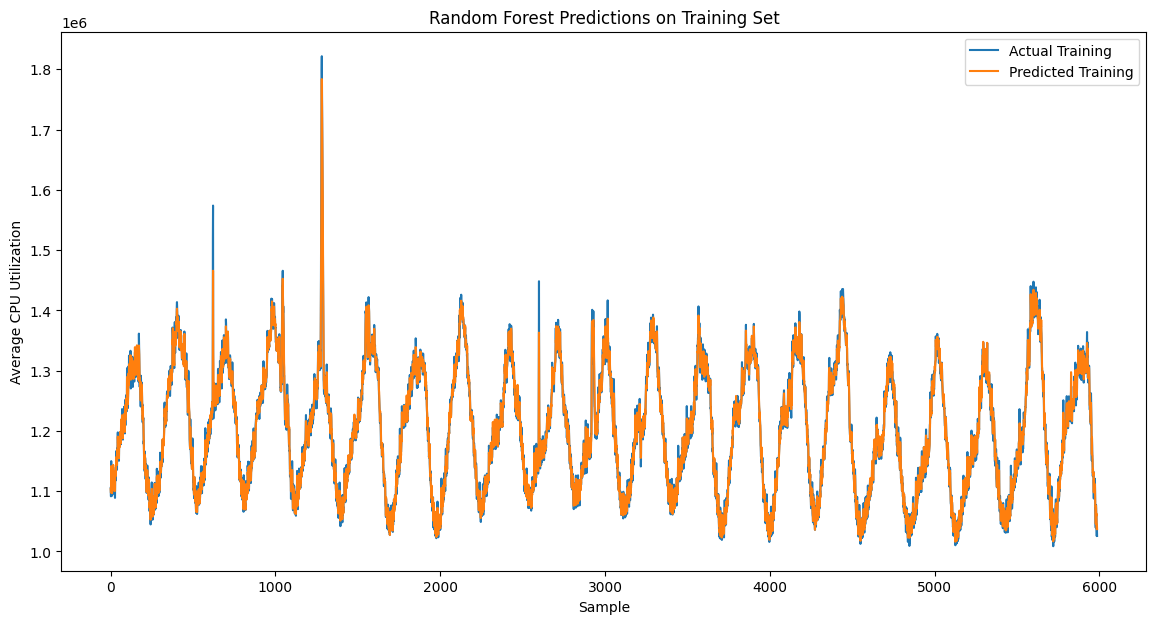

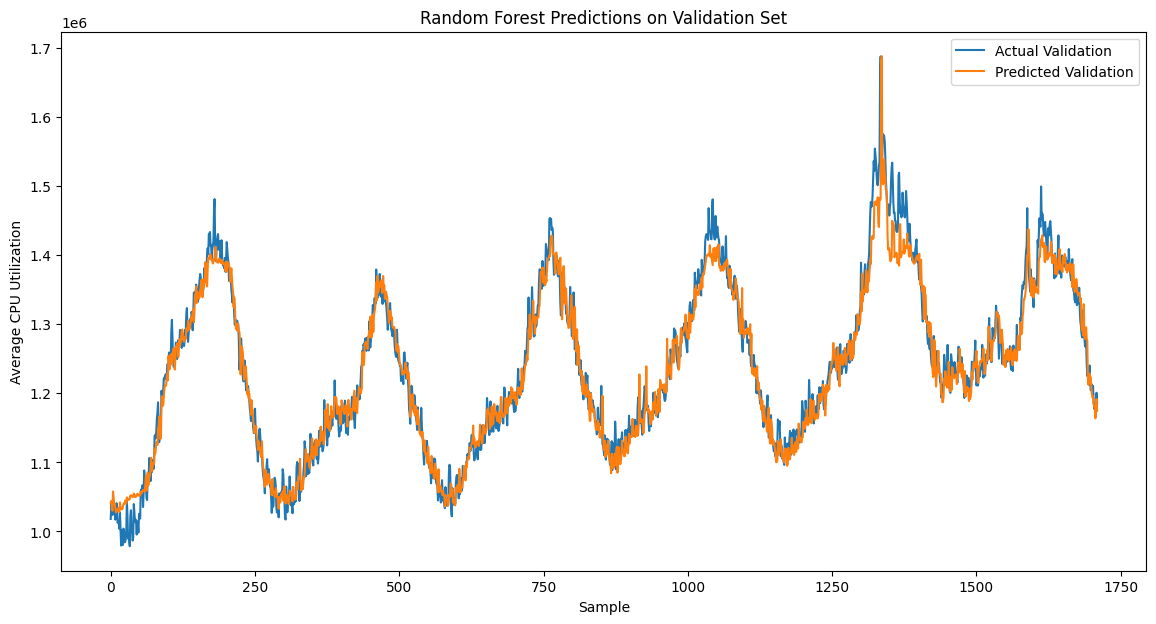

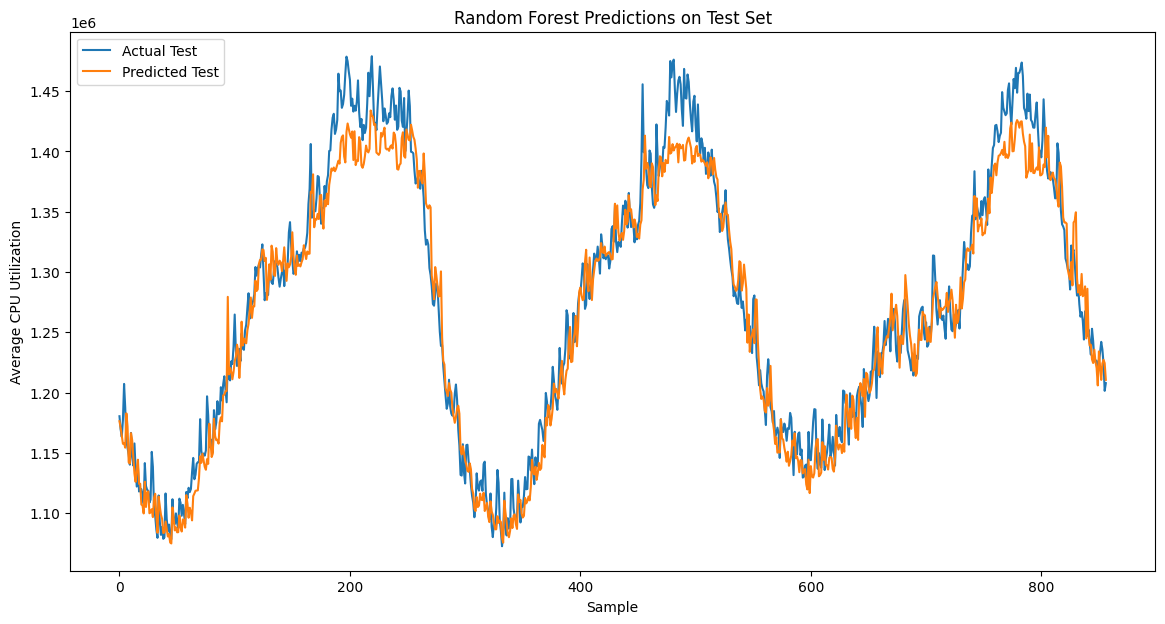

In [ ]:
# Make predictions
train_predictions = rf_model.predict(X_train_flat)
val_predictions = rf_model.predict(X_val_flat)
test_predictions = rf_model.predict(X_test_flat)

# Rescale predictions back to original scale
train_predictions_rescaled = target_scaler.inverse_transform(train_predictions.reshape(-1, 1)).reshape(-1)
val_predictions_rescaled = target_scaler.inverse_transform(val_predictions.reshape(-1, 1)).reshape(-1)
test_predictions_rescaled = target_scaler.inverse_transform(test_predictions.reshape(-1, 1)).reshape(-1)
y_train_rescaled = target_scaler.inverse_transform(y_train.reshape(-1, 1)).reshape(-1)
y_val_rescaled = target_scaler.inverse_transform(y_val.reshape(-1, 1)).reshape(-1)
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)

# Evaluate the model
train_mae = mean_absolute_error(y_train_rescaled, train_predictions_rescaled)
train_mape = mean_absolute_percentage_error(y_train_rescaled, train_predictions_rescaled)
train_accuracy = 1 - train_mape

val_mae = mean_absolute_error(y_val_rescaled, val_predictions_rescaled)
val_mape = mean_absolute_percentage_error(y_val_rescaled, val_predictions_rescaled)
val_accuracy = 1 - val_mape

test_mae = mean_absolute_error(y_test_rescaled, test_predictions_rescaled)
test_mape = mean_absolute_percentage_error(y_test_rescaled, test_predictions_rescaled)
test_accuracy = 1 - test_mape

print(f'Training MAE: {train_mae}, Training MAPE: {train_mape}, Training Accuracy: {train_accuracy}')
print(f'Validation MAE: {val_mae}, Validation MAPE: {val_mape}, Validation Accuracy: {val_accuracy}')
print(f'Test MAE: {test_mae}, Test MAPE: {test_mape}, Test Accuracy: {test_accuracy}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_train_rescaled, label='Actual Training')
plt.plot(train_predictions_rescaled, label='Predicted Training')
plt.legend()
plt.title('Random Forest Predictions on Training Set')
plt.xlabel('Sample')
plt.ylabel('Average CPU Utilization')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(y_val_rescaled, label='Actual Validation')
plt.plot(val_predictions_rescaled, label='Predicted Validation')
plt.legend()
plt.title('Random Forest Predictions on Validation Set')
plt.xlabel('Sample')
plt.ylabel('Average CPU Utilization')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label='Actual Test')
plt.plot(test_predictions_rescaled, label='Predicted Test')
plt.legend()
plt.title('Random Forest Predictions on Test Set')
plt.xlabel('Sample')
plt.ylabel('Average CPU Utilization')
plt.show()

In [ ]:
rf_model = RandomForestRegressor(
    n_estimators=250,
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=seed
)

# Fit the model
rf_model.fit(X_train_flat, y_train)

RandomForestRegressor(max_depth=25, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=5, n_estimators=250, random_state=42)

Training MAE: 6032.2949508311785, Training MAPE: 0.0049149433981254915, Training Accuracy: 0.9950850566018745
Validation MAE: 24360.56852054268, Validation MAPE: 0.019053448403065665, Validation Accuracy: 0.9809465515969343
Test MAE: 26217.575398167988, Test MAPE: 0.019996704504335164, Test Accuracy: 0.9800032954956648


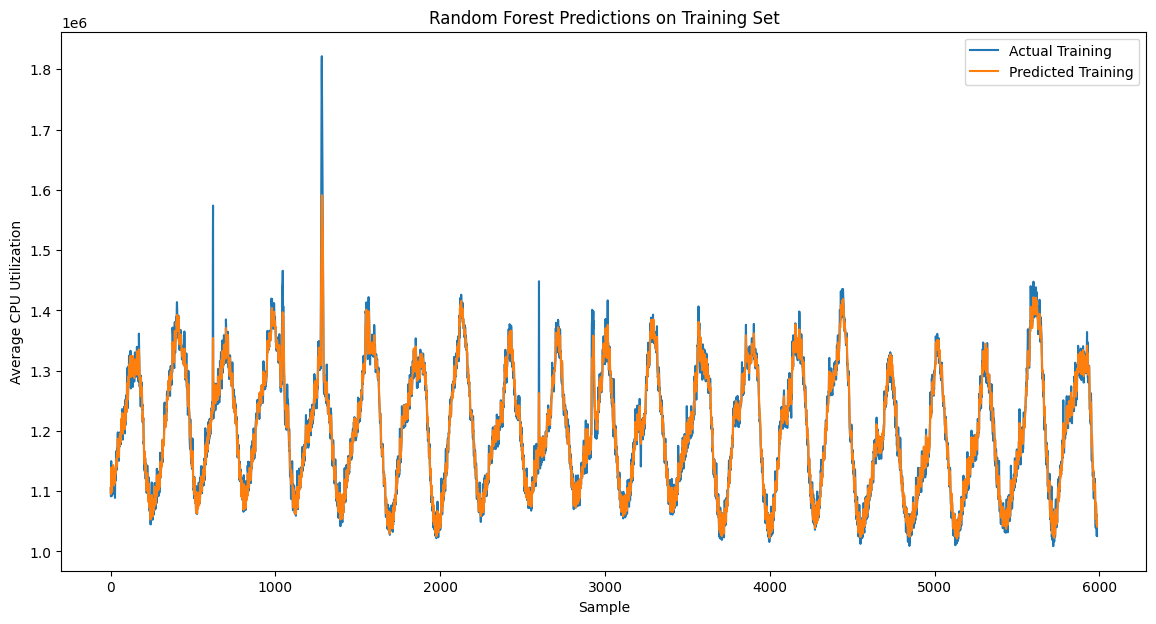

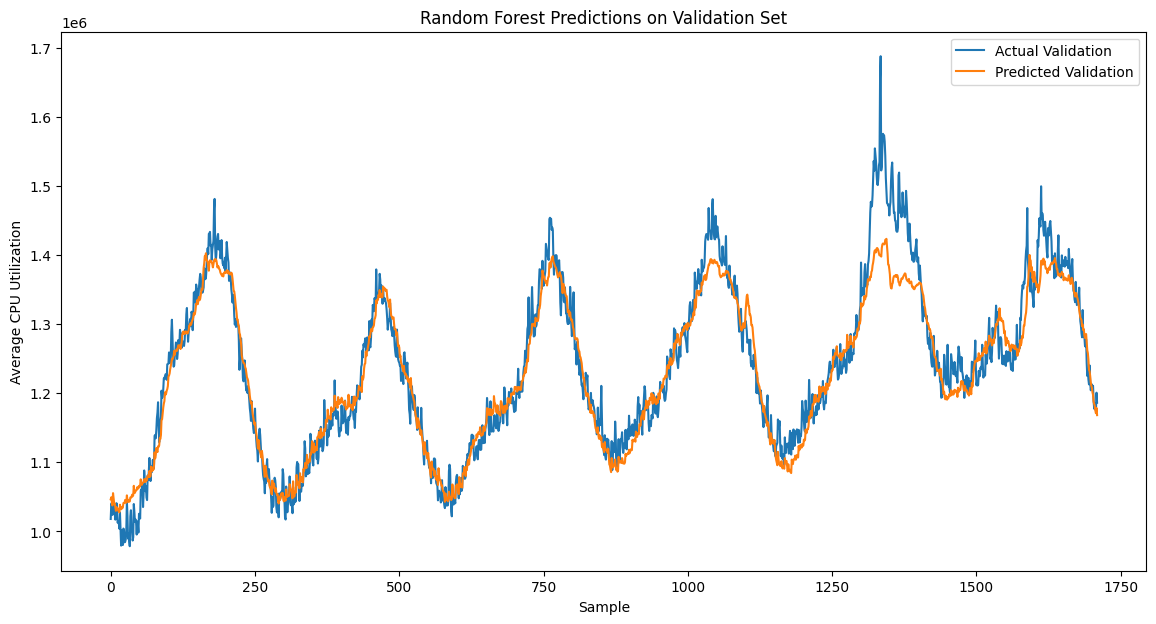

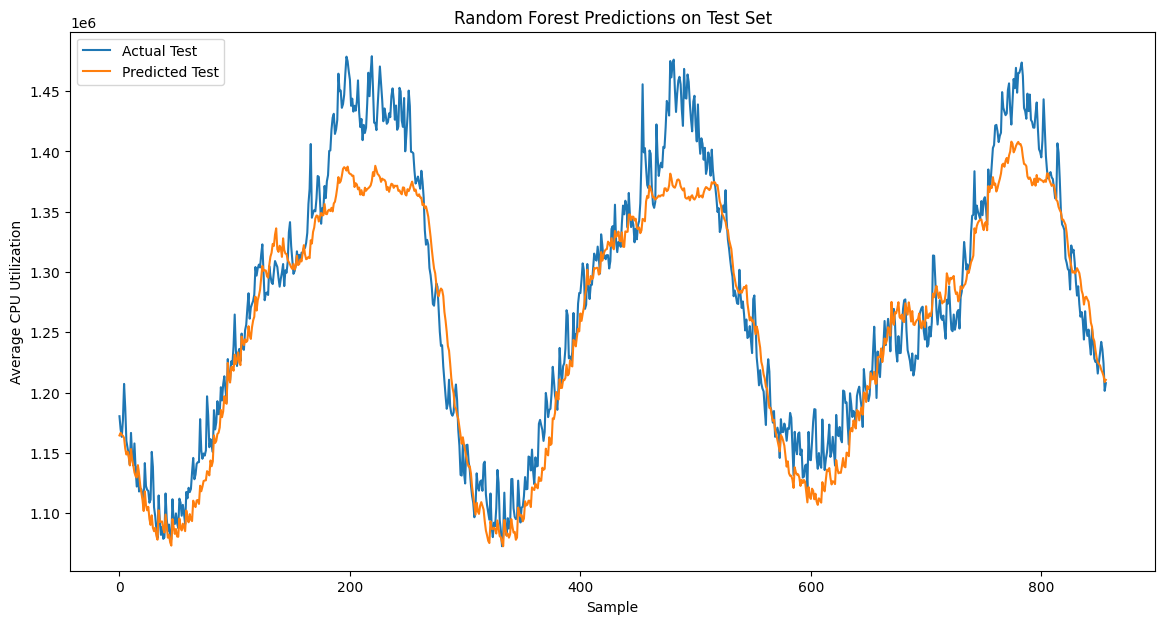

In [ ]:
# Make predictions
train_predictions = rf_model.predict(X_train_flat)
val_predictions = rf_model.predict(X_val_flat)
test_predictions = rf_model.predict(X_test_flat)

# Rescale predictions back to original scale
train_predictions_rescaled = target_scaler.inverse_transform(train_predictions.reshape(-1, 1)).reshape(-1)
val_predictions_rescaled = target_scaler.inverse_transform(val_predictions.reshape(-1, 1)).reshape(-1)
test_predictions_rescaled = target_scaler.inverse_transform(test_predictions.reshape(-1, 1)).reshape(-1)
y_train_rescaled = target_scaler.inverse_transform(y_train.reshape(-1, 1)).reshape(-1)
y_val_rescaled = target_scaler.inverse_transform(y_val.reshape(-1, 1)).reshape(-1)
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)

# Evaluate the model
train_mae = mean_absolute_error(y_train_rescaled, train_predictions_rescaled)
train_mape = mean_absolute_percentage_error(y_train_rescaled, train_predictions_rescaled)
train_accuracy = 1 - train_mape

val_mae = mean_absolute_error(y_val_rescaled, val_predictions_rescaled)
val_mape = mean_absolute_percentage_error(y_val_rescaled, val_predictions_rescaled)
val_accuracy = 1 - val_mape

test_mae = mean_absolute_error(y_test_rescaled, test_predictions_rescaled)
test_mape = mean_absolute_percentage_error(y_test_rescaled, test_predictions_rescaled)
test_accuracy = 1 - test_mape

print(f'Training MAE: {train_mae}, Training MAPE: {train_mape}, Training Accuracy: {train_accuracy}')
print(f'Validation MAE: {val_mae}, Validation MAPE: {val_mape}, Validation Accuracy: {val_accuracy}')
print(f'Test MAE: {test_mae}, Test MAPE: {test_mape}, Test Accuracy: {test_accuracy}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_train_rescaled, label='Actual Training')
plt.plot(train_predictions_rescaled, label='Predicted Training')
plt.legend()
plt.title('Random Forest Predictions on Training Set')
plt.xlabel('Sample')
plt.ylabel('Average CPU Utilization')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(y_val_rescaled, label='Actual Validation')
plt.plot(val_predictions_rescaled, label='Predicted Validation')
plt.legend()
plt.title('Random Forest Predictions on Validation Set')
plt.xlabel('Sample')
plt.ylabel('Average CPU Utilization')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label='Actual Test')
plt.plot(test_predictions_rescaled, label='Predicted Test')
plt.legend()
plt.title('Random Forest Predictions on Test Set')
plt.xlabel('Sample')
plt.ylabel('Average CPU Utilization')
plt.show()

Best Model

In [ ]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=None,  # Changed from 'auto' to None
    random_state=seed
)

# Fit the model
rf_model.fit(X_train_flat, y_train)

RandomForestRegressor(max_depth=20, max_features=None, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=200, random_state=42)

Training MAE: 5096.387822362535, Training MAPE: 0.004174024476509207, Training Accuracy: 0.9958259755234908
Validation MAE: 18503.15501304965, Validation MAPE: 0.014716678478455973, Validation Accuracy: 0.9852833215215441
Test MAE: 18031.7717920602, Test MAPE: 0.013846616828206535, Test Accuracy: 0.9861533831717935


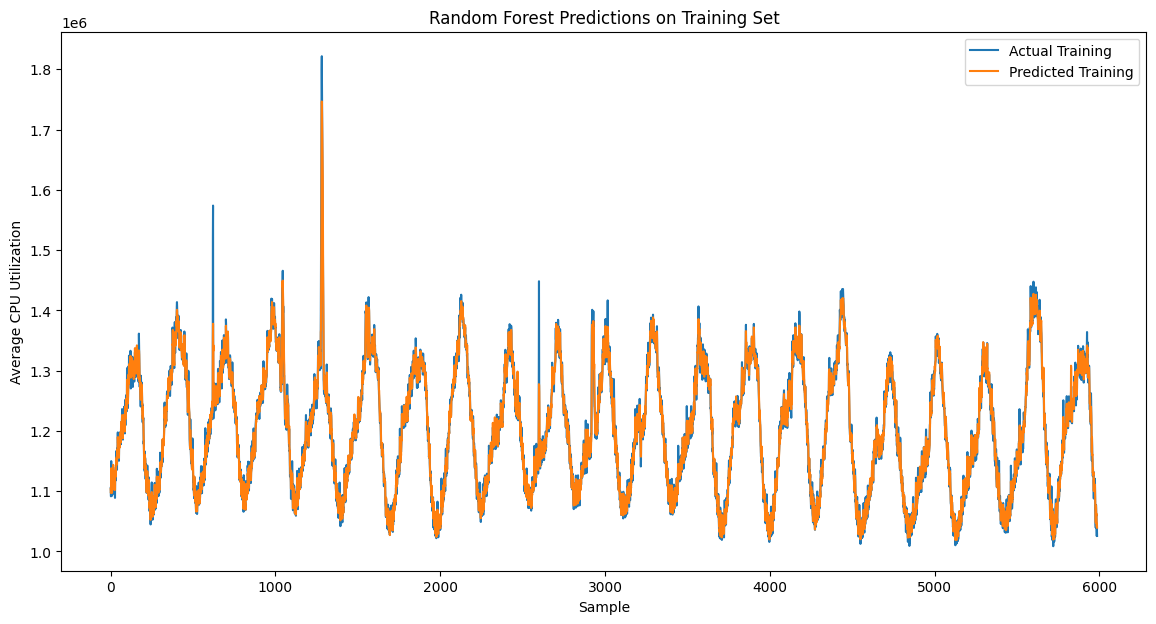

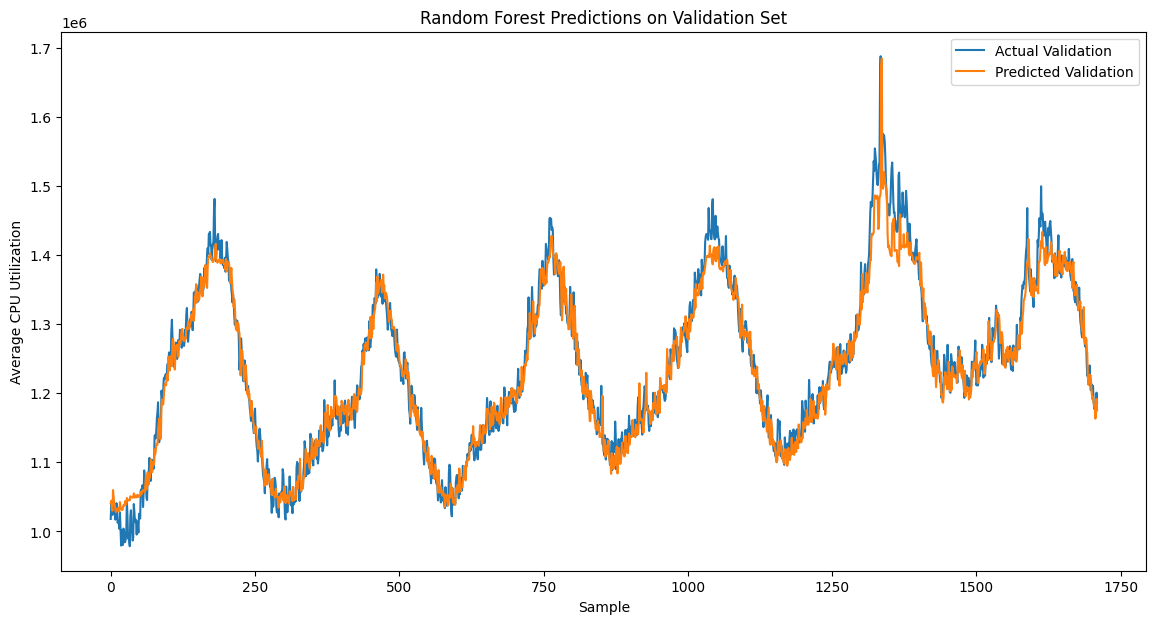

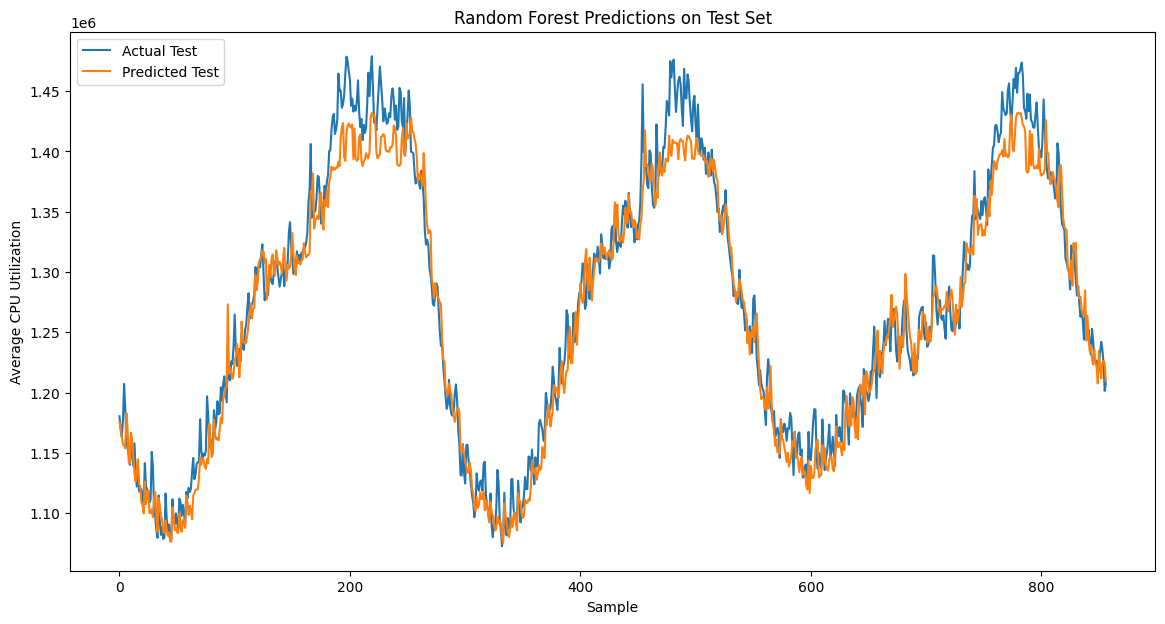

In [ ]:
# Make predictions
train_predictions = rf_model.predict(X_train_flat)
val_predictions = rf_model.predict(X_val_flat)
test_predictions = rf_model.predict(X_test_flat)

# Rescale predictions back to original scale
train_predictions_rescaled = target_scaler.inverse_transform(train_predictions.reshape(-1, 1)).reshape(-1)
val_predictions_rescaled = target_scaler.inverse_transform(val_predictions.reshape(-1, 1)).reshape(-1)
test_predictions_rescaled = target_scaler.inverse_transform(test_predictions.reshape(-1, 1)).reshape(-1)
y_train_rescaled = target_scaler.inverse_transform(y_train.reshape(-1, 1)).reshape(-1)
y_val_rescaled = target_scaler.inverse_transform(y_val.reshape(-1, 1)).reshape(-1)
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)

# Evaluate the model
train_mae = mean_absolute_error(y_train_rescaled, train_predictions_rescaled)
train_mape = mean_absolute_percentage_error(y_train_rescaled, train_predictions_rescaled)
train_accuracy = 1 - train_mape

val_mae = mean_absolute_error(y_val_rescaled, val_predictions_rescaled)
val_mape = mean_absolute_percentage_error(y_val_rescaled, val_predictions_rescaled)
val_accuracy = 1 - val_mape

test_mae = mean_absolute_error(y_test_rescaled, test_predictions_rescaled)
test_mape = mean_absolute_percentage_error(y_test_rescaled, test_predictions_rescaled)
test_accuracy = 1 - test_mape

print(f'Training MAE: {train_mae}, Training MAPE: {train_mape}, Training Accuracy: {train_accuracy}')
print(f'Validation MAE: {val_mae}, Validation MAPE: {val_mape}, Validation Accuracy: {val_accuracy}')
print(f'Test MAE: {test_mae}, Test MAPE: {test_mape}, Test Accuracy: {test_accuracy}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_train_rescaled, label='Actual Training')
plt.plot(train_predictions_rescaled, label='Predicted Training')
plt.legend()
plt.title('Random Forest Predictions on Training Set')
plt.xlabel('Sample')
plt.ylabel('Average CPU Utilization')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(y_val_rescaled, label='Actual Validation')
plt.plot(val_predictions_rescaled, label='Predicted Validation')
plt.legend()
plt.title('Random Forest Predictions on Validation Set')
plt.xlabel('Sample')
plt.ylabel('Average CPU Utilization')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label='Actual Test')
plt.plot(test_predictions_rescaled, label='Predicted Test')
plt.legend()
plt.title('Random Forest Predictions on Test Set')
plt.xlabel('Sample')
plt.ylabel('Average CPU Utilization')
plt.show()

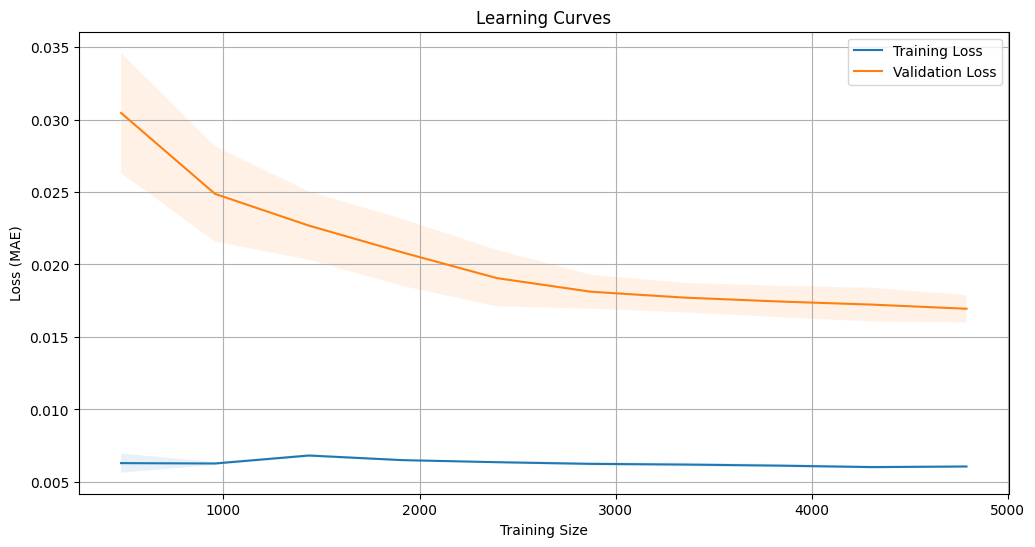

In [ ]:
from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    rf_model, X_train_flat, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=seed
)

train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = -val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

# Plot learning curves
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Loss')
plt.plot(train_sizes, val_scores_mean, label='Validation Loss')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1)
plt.xlabel('Training Size')
plt.ylabel('Loss (MAE)')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.show()

Training MAE: 5096.387822362535, Training MAPE: 0.004174024476509207, Training Accuracy: 0.9958259755234908
Validation MAE: 18503.15501304965, Validation MAPE: 0.014716678478455973, Validation Accuracy: 0.9852833215215441
Test MAE: 18031.7717920602, Test MAPE: 0.013846616828206535, Test Accuracy: 0.9861533831717935


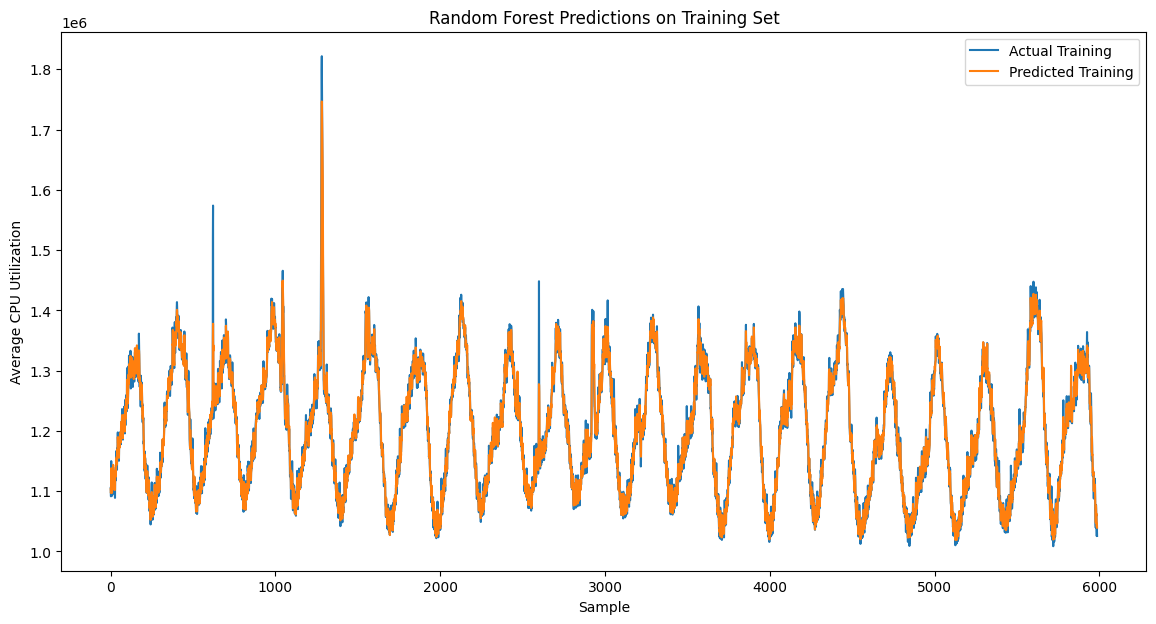

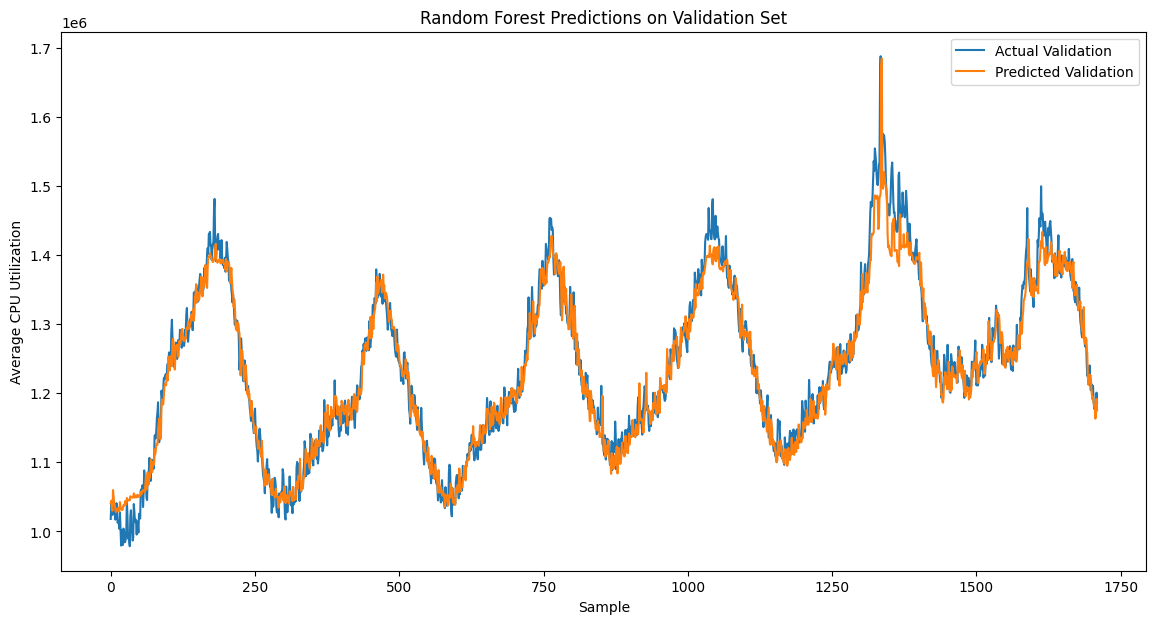

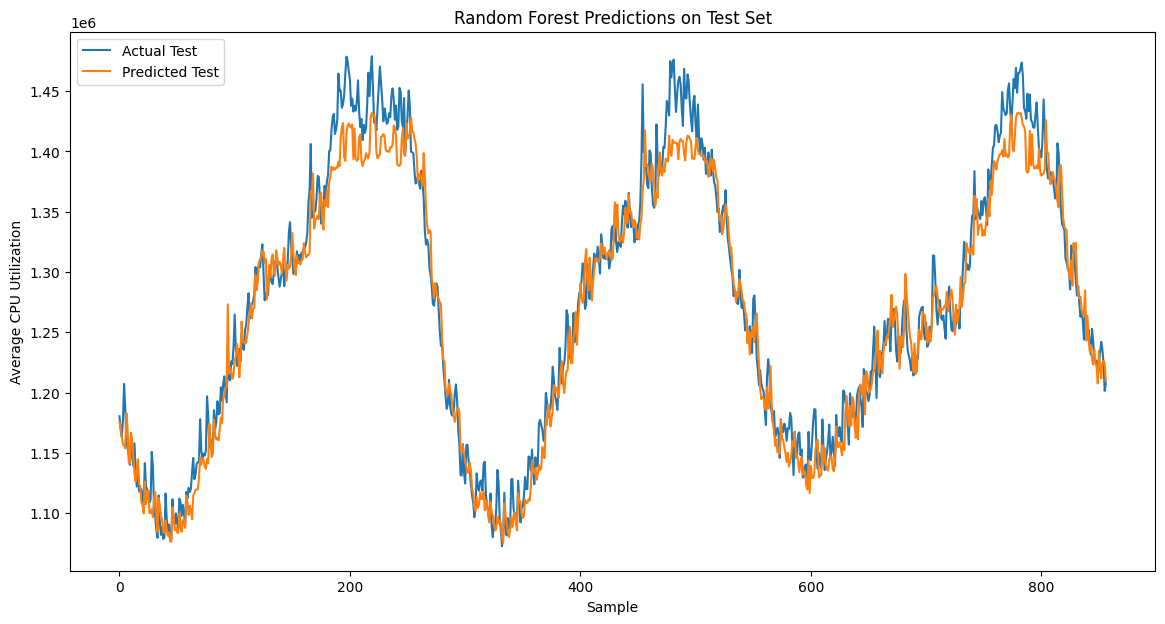

In [ ]:
# Make predictions
train_predictions = rf_model.predict(X_train_flat)
val_predictions = rf_model.predict(X_val_flat)
test_predictions = rf_model.predict(X_test_flat)

# Rescale predictions back to original scale
train_predictions_rescaled = target_scaler.inverse_transform(train_predictions.reshape(-1, 1)).reshape(-1)
val_predictions_rescaled = target_scaler.inverse_transform(val_predictions.reshape(-1, 1)).reshape(-1)
test_predictions_rescaled = target_scaler.inverse_transform(test_predictions.reshape(-1, 1)).reshape(-1)
y_train_rescaled = target_scaler.inverse_transform(y_train.reshape(-1, 1)).reshape(-1)
y_val_rescaled = target_scaler.inverse_transform(y_val.reshape(-1, 1)).reshape(-1)
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)

# Evaluate the model
train_mae = mean_absolute_error(y_train_rescaled, train_predictions_rescaled)
train_mape = mean_absolute_percentage_error(y_train_rescaled, train_predictions_rescaled)
train_accuracy = 1 - train_mape

val_mae = mean_absolute_error(y_val_rescaled, val_predictions_rescaled)
val_mape = mean_absolute_percentage_error(y_val_rescaled, val_predictions_rescaled)
val_accuracy = 1 - val_mape

test_mae = mean_absolute_error(y_test_rescaled, test_predictions_rescaled)
test_mape = mean_absolute_percentage_error(y_test_rescaled, test_predictions_rescaled)
test_accuracy = 1 - test_mape

print(f'Training MAE: {train_mae}, Training MAPE: {train_mape}, Training Accuracy: {train_accuracy}')
print(f'Validation MAE: {val_mae}, Validation MAPE: {val_mape}, Validation Accuracy: {val_accuracy}')
print(f'Test MAE: {test_mae}, Test MAPE: {test_mape}, Test Accuracy: {test_accuracy}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_train_rescaled, label='Actual Training')
plt.plot(train_predictions_rescaled, label='Predicted Training')
plt.legend()
plt.title('Random Forest Predictions on Training Set')
plt.xlabel('Sample')
plt.ylabel('Average CPU Utilization')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(y_val_rescaled, label='Actual Validation')
plt.plot(val_predictions_rescaled, label='Predicted Validation')
plt.legend()
plt.title('Random Forest Predictions on Validation Set')
plt.xlabel('Sample')
plt.ylabel('Average CPU Utilization')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label='Actual Test')
plt.plot(test_predictions_rescaled, label='Predicted Test')
plt.legend()
plt.title('Random Forest Predictions on Test Set')
plt.xlabel('Sample')
plt.ylabel('Average CPU Utilization')
plt.show()